# NNTI Assignment 3

Name 1: Mahsa Amani <br>
Student id 1: 7064006 <br>
Email 1: maam00002@stud.uni-saarland.de <br>

Name 2: Saye Jarollahi<br>
Student id 2: 7073520<br>
Email 2:  saja00006@stud.uni-saarland.de<br>

Name 3: <br>
Student id 3:  <br>
Email 3: <br>

**Instructions:** Read each question carefully. <br/>
Make sure you appropriately comment your code wherever required. Your final submission should contain the completed Notebook and the respective  files for any additional exercises necessary. There is no need to resubmit the data files should they be provided separately. <br>


Upload the zipped folder on CMS. Please follow the naming convention of **Name1_id1_Name2_id2_Name3_id3.zip **. Only one member of the group should make the submisssion.


In [4]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

### Data setup: (Provided for you)
We are using the MNIST dataset from [Pytorch](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html). For the sake of simplicity, we are only using only the first 2000 samples from the test set. Here, we have normalized the images to the range [0, 1], then reshaped each image to a tensor vector of size 784 and stack them together to get an array of 2000x784.

In [5]:
# Load MNIST data
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Extract the first 2000 samples
data = mnist_data.data[:2000].float()
labels = mnist_data.targets[:2000]

# Normalize the data to [0, 1]
data /= 255.0

# Reshape the data
n, d = data.size(0), data.size(1) * data.size(2)  # n = 2000, d = 784
X = data.view(n, d)

### a. Eigendecomposition [1 point]


i.   Complete the function `eigen_decomp()`. Take care to:

- Center the input data `X` by subtracting the mean of each feature.
- Calculate the covariance matrix and performs eigendecomposition to obtain eigenvalues and eigenvectors.
- Compute the cumulative variance explained by each component and return it.


ii.   Plot the cumulative explained variance against the number of principal components.

In [8]:
def eigen_decomp(X):
  """
    Performs eigendecomposition on the covariance matrix of the input data `X`.

    Args:
        X (torch.Tensor): A 2D tensor where rows represent samples and columns represent features.

    Returns:
        tuple: A tuple containing:
            - eigvals (torch.Tensor): Eigenvalues of the covariance matrix, representing variance explained by each principal component.
            - eigvecs (torch.Tensor): Eigenvectors of the covariance matrix, each representing a principal component direction.
            - cumulative_variance_explained (np.ndarray): Cumulative variance explained by each principal component, as a numpy array.
  """
  X = X - X.mean(dim=0)

  XTX = X.T@X
  cov_matrix = XTX / (XTX.shape[0] - 1)
  eigvals, eigvecs = torch.linalg.eigh(cov_matrix)  

  sorted_indices = torch.argsort(eigvals, descending=True)
  eigvals = eigvals[sorted_indices]
  eigvecs = eigvecs[:, sorted_indices]

  cumulative_variance_explained = np.cumsum(eigvals.numpy()) / eigvals.sum().item()

  return eigvals, eigvecs, cumulative_variance_explained

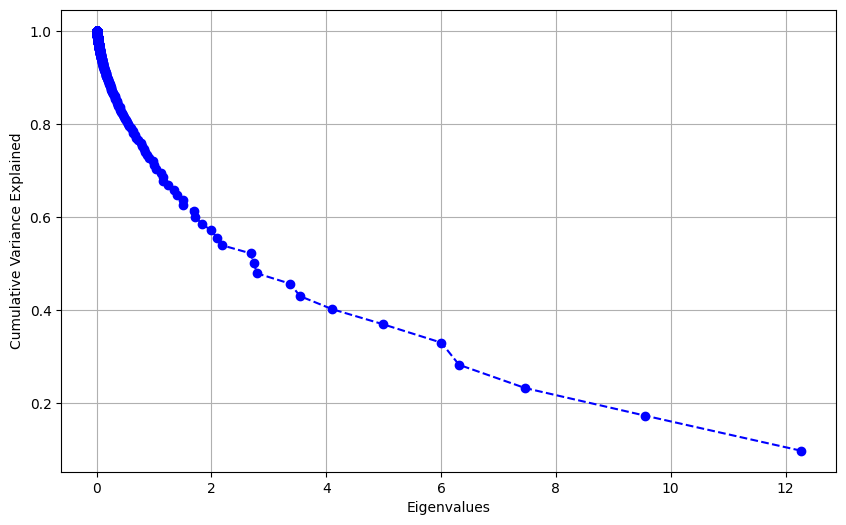

In [15]:
eigvals, eigvecs, cumulative_variance_explained = eigen_decomp(X)

# Plot the cumulative variance against the principal components
##TODO##

plt.figure(figsize=(10, 6))
    
plt.plot(eigvals, cumulative_variance_explained, marker='o', linestyle='--', color='b')
plt.xlabel('Eigenvalues')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()




### Answer the below question: [0.25 points]

Q: What do you think happens when we reduce the number of principal components $p$?

Space for answer: As we reduce number of principal components, we lose some information. Hence, the approximation error increases. On the other hand, we can compress data by reducing number of p. Also, as p decreases, the cumulative variance explained by the retained components also decreases.

### b. PCA [1 point]

Complete the function `pca_reconstruction_error()`. It should:
- Center the input data `X` by subtracting the mean of each feature (again).
- Projects `X` onto the top `p` principal components, reconstructs it.
- Compute the normalized reconstruction error in terms of the Frobenius norm, i.e. $e_{p} = \frac{\|x - \hat{x}_p\|_{F}}{\|x\|_{F}}$, where $x$ denotes the input matrix and $\hat{x}_p$ denotes the recovered matrix associated to each $p$.


In [23]:
def pca_reconstruction_error(X, p, eigvecs):
   """
    Calculates the PCA reconstruction error for the given data `X` using the top `p` principal components.

    Args:
        X (torch.Tensor): A 2D tensor where rows represent samples and columns represent features.
        p (int): The number of principal components to use for reconstruction.
        eigvecs (torch.Tensor): Eigenvectors obtained from PCA, with each column representing a principal component direction.

    Returns:
        tuple: A tuple containing:
            - error (float): The normalized Frobenius norm of the difference between `X` and its PCA reconstruction, representing the reconstruction error.
            - X_reconstructed (torch.Tensor): The reconstructed data using `p` principal components.
   """
   X = X - X.mean(dim=0)
   top_p_eigvecs = eigvecs[:, :p]
   X_projected = X@top_p_eigvecs
   X_reconstructed = X_projected @ top_p_eigvecs.T
   reconstruction_error = torch.norm(X - X_reconstructed, 'fro') / torch.norm(X, 'fro')
   
   return reconstruction_error.item(), X_reconstructed

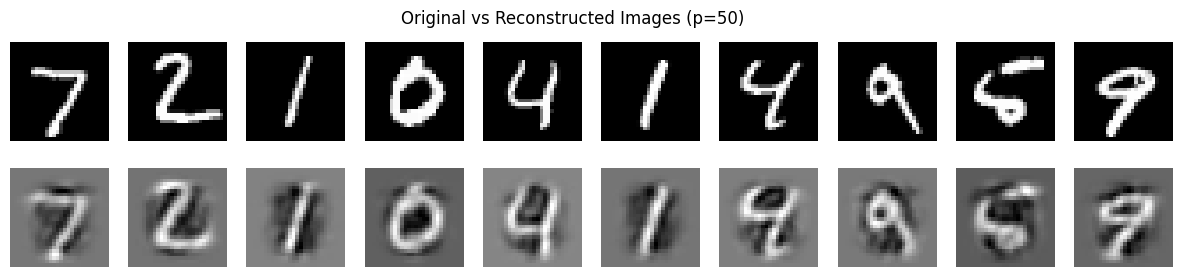

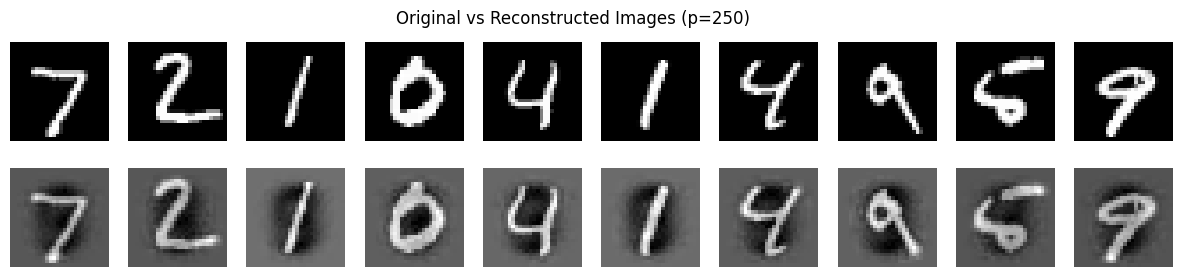

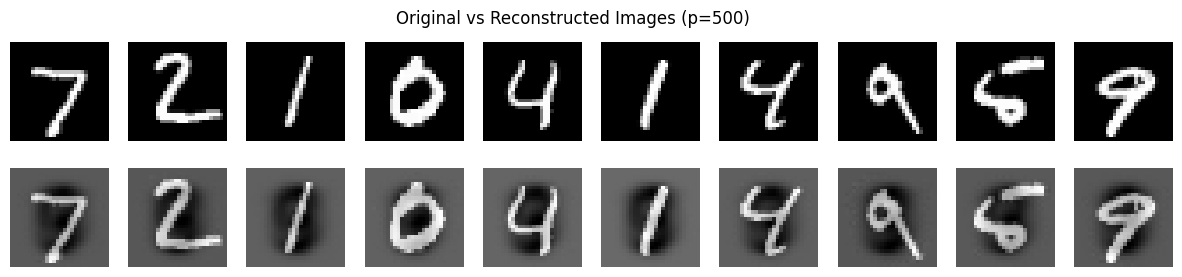

Frobenius Norm Errors: [0.4177590012550354, 0.12825937569141388, 0.015557396225631237]


In [24]:
### Driver code for the previousky defined functions
frobenius_norm = []

# Evaluate for p = 50, 250, 500
for p in [50, 250, 500]:
    error, X_reconstructed = pca_reconstruction_error(X, p, eigvecs)
    frobenius_norm.append(error)

    # Visualize some original and reconstructed images
    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axes[0, i].imshow(X[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle(f'Original vs Reconstructed Images (p={p})')
    plt.show()

print(f"Frobenius Norm Errors: {frobenius_norm}")

### c. Noisy Data Generation [1.5 points]

i.   Complete the function `mnist_noised()` to generate noisy versions of the mnist data.

ii.   Visualize the noisy images and compare them with their corresponding original images.

iii.   Plot the cumulative explained variance of the **noisy data** along with the **original data** versus the number of components.

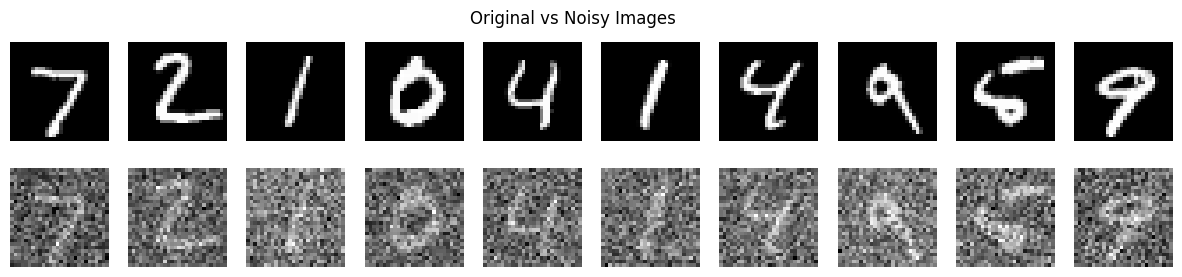

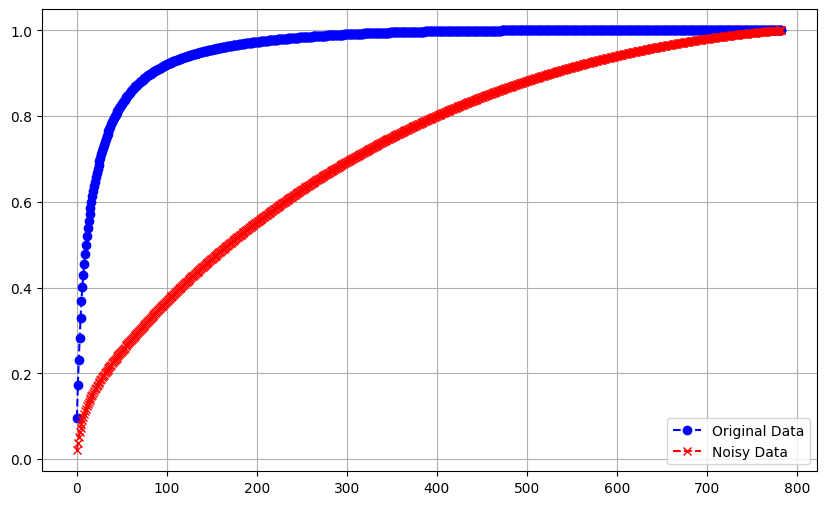

In [46]:
# Add Gaussian noise
def mnist_noised(X, noise_var=0.25):
   """
    Adds Gaussian noise to the input data `X`.

    Args:
        X (torch.Tensor): A 2D tensor where rows represent samples and columns represent features (e.g., flattened images).
        noise_var (float, optional): The variance of the Gaussian noise to be added. Default is 0.25.

    Returns:
        torch.Tensor: A tensor with Gaussian noise added to each element of `X`..
   """
   std = torch.sqrt(torch.tensor([noise_var]))
   mean = torch.zeros(X.shape)
   std = torch.zeros(X.shape) + std
   noise =  torch.normal(mean=mean, std=std)
   return X + noise

# Add Gaussian noise to the data
noisy_data = mnist_noised(X)

# Plot some original and noisy images
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axes[0, i].imshow(X[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(noisy_data[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
plt.suptitle('Original vs Noisy Images')
plt.show()

# Compute eigen decomposition for the noisy data
eigvals_noisy, eigvecs_noisy, cumulative_variance_explained_noisy = eigen_decomp(noisy_data)

# Plot the cumulative variance for noisy data and original data
plt.figure(figsize=(10, 6))
    
plt.plot(cumulative_variance_explained, marker='o', linestyle='--', color='b', label="Original Data")
plt.plot(cumulative_variance_explained_noisy, marker='x', linestyle='--', color='r', label='Noisy Data')

plt.grid(True)
plt.legend()
plt.show()


### Answer the below question: [0.25 points]

Q: How do the 2 plots compare? Are they similar?

Space for answer: As we can see in the above plot, the noisy data cumulates later than the original data. Since we miss some parts of the information in the process and noise is added, random fluctuations that are not meaningful perturb the output. Hence, the cumulative variance increases less than the original images because each principal component contains less information. 

### d. Image Denoising [1 point]



i.   Complete the function `pca_reconstruction_noisy()`. It should:
- Add Gaussian noise of a specified variance ($\sigma^{2}$) to the original data.
- Compute the eigen decomposition on the noisy data, retaining only the top `p` principal components.
- Calculate the reconstruction error to quantify the quality of denoising.

ii. Plot the denoised images agianst the noisy data for visual comparison.



In [47]:
def pca_reconstruction_noisy(X, noise_var=0.05, p=100):
   """
    Adds Gaussian noise to input data `X`, performs PCA-based dimensionality reduction,
    and reconstructs the denoised images using the top `p` principal components.

    Args:
        X (torch.Tensor): A 2D tensor where rows represent samples and columns represent features (e.g., flattened images).
        noise_var (float, optional): Variance of the Gaussian noise to be added to `X`. Default is 0.05.
        p (int, optional): Number of principal components to retain for PCA-based reconstruction. Default is 100.

    Returns:
        tuple: A tuple containing:
            - error (float): The normalized reconstruction error after applying PCA to the noisy data.
            - X_reconstructed (torch.Tensor): A 2D tensor of reconstructed data using the top `p` components, representing the denoised images.
   """
   X_noisy = mnist_noised(X, noise_var)
   eigvals, eigvecs, cumulative_variance_explained = eigen_decomp(X_noisy)
   top_p_eigvecs = eigvecs[:, :p]
   X_projected = X_noisy@top_p_eigvecs
   X_reconstructed = X_projected @ top_p_eigvecs.T
   error = torch.norm(X_noisy - X_reconstructed, p='fro') / torch.norm(X, p='fro')
   return error, X_reconstructed
   

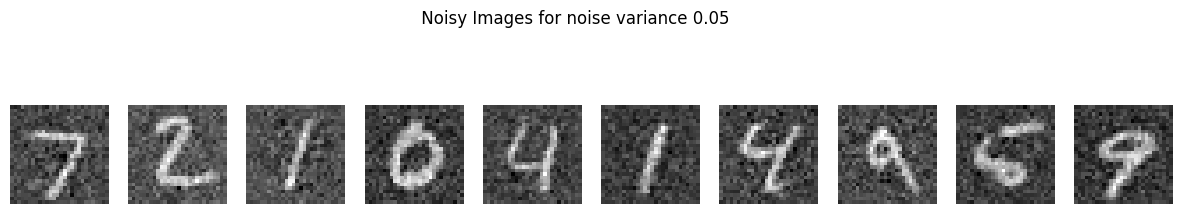

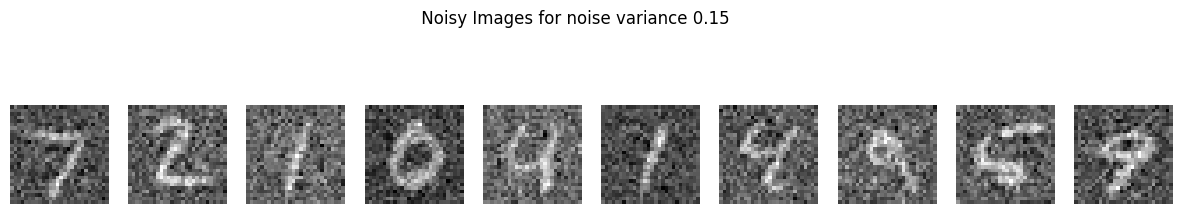

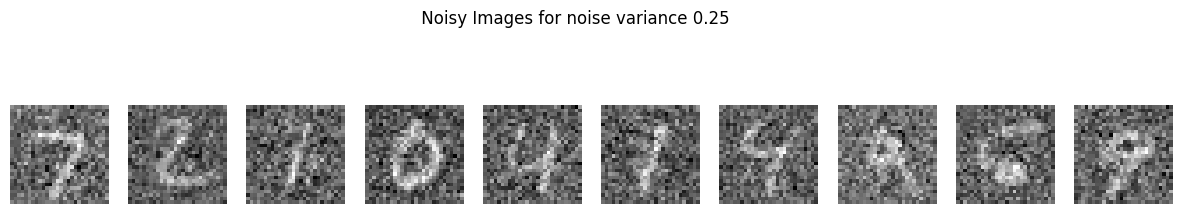

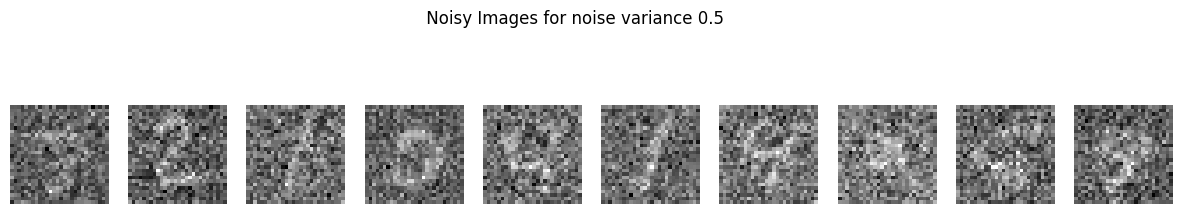

Reconstruction Errors for different noise levels: [tensor(0.5576), tensor(0.9247), tensor(1.1770), tensor(1.6424)]


In [55]:
### Driver code for the previousky defined functions
noise_levels = [0.05, 0.15, 0.25, 0.5]
errors = []

for noise_var in noise_levels:
    error, X_reconstructed = pca_reconstruction_noisy(X, noise_var, p=200)
    errors.append(error)

    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for i in range(10):
        axes[i].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        axes[i].axis('off')
        
    plt.suptitle(f' Noisy Images for noise variance {noise_var}')
    plt.show()
    

print(f"Reconstruction Errors for different noise levels: {errors}")